# Notebook de modelos de regressão

## Importação das bibliotecas

In [15]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

In [16]:
# Configurar paleta de cores e estilo

# Matplotlib
mpl.rcParams["figure.figsize"] = (20, 7)
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["figure.dpi"] = 100

# Seaborn
sns.set_style('whitegrid', {"grid.color": ".8", "grid.linestyle": "--"})
sns.set_palette(palette='mako')

## Aquisição dos dados

In [32]:
input_path = '../data/processed/dados_historicos_ibovespa_2015-2025_processed.csv'

df = pd.read_csv(input_path, index_col='ds', parse_dates=['ds'])
df.tail()

,close,open,high,low,volume,daily_return,return_lag_1,return_lag_2,return_lag_3,return_lag_4,...,atr_14,obv,day_of_week,day_of_month,month,year,eua_return_lag1,china_return_lag1,europe_return_lag1,oil_return_lag1
ds,,,,,,,,,,,,,,,,,,,,,
2025-06-12,137800,137127,137931,136175,7.120000e+09,0.0049,0.0051,0.0054,-0.0030,-0.0010,...,1746.368879,1.365133e+11,3,12,6,2025,-0.002744,0.005170,-0.002228,0.043368
2025-06-13,137213,137800,137800,136586,8.630000e+09,-0.0043,0.0049,0.0051,0.0054,-0.0030,...,1708.342531,1.278833e+11,4,13,6,2025,0.003822,0.000101,-0.002472,-0.005876
2025-06-16,139256,137212,139988,137212,7.620000e+09,0.0149,-0.0043,0.0049,0.0051,0.0054,...,1784.603778,1.355033e+11,0,16,6,2025,-0.011296,-0.007542,-0.008685,0.070213
2025-06-17,138840,139256,139497,138293,8.380000e+09,-0.0030,0.0149,-0.0043,0.0049,0.0051,...,1743.132080,1.271233e+11,1,17,6,2025,0.009393,0.003474,0.006268,-0.013472
2025-06-18,138717,138844,139161,138443,8.320000e+09,-0.0009,-0.0030,0.0149,-0.0043,0.0049,...,1669.908360,1.188033e+11,2,18,6,2025,-0.008352,-0.000391,-0.007578,0.043971


## Pré-processamento dos dados

O teste ADF (Augmented Dickey-Fuller) verifica se a série é estacionaria, ou seja, como as propriedades mudam ao longo do tempo.

* Hipótese Nula (H₀): A série NÃO é estacionária (ela possui uma raiz unitária).
* Hipótese Alternativa (H₁): A série É estacionária (ela não possui uma raiz unitária).

In [5]:
def is_stationary(series):

  adf = adfuller(series)
  print(f'Valor-p do Teste ADF: {adf[1]:.4f}')

  # Nível de significância de 95%
  if adf[1] > 0.05:
    print('Não rejeitar a Hipótese Nula: a série não é estacionária')
  else:
    print('Rejeitar a Hipótese Nula: a série é estacionária')

# Retorno diário
print('Retorno diário')
is_stationary(df['daily_return'].values)

print('--------')

# Fechamento
print('Fechamento')
is_stationary(df['close'].values)

Retorno diário
Valor-p do Teste ADF: 0.0000
Rejeitar a Hipótese Nula: a série é estacionária
--------
Fechamento
Valor-p do Teste ADF: 0.6212
Não rejeitar a Hipótese Nula: a série não é estacionária


Modelos de Machine Learning funcionam melhor e generalizam de forma mais robusta quando alimentados com features estacionárias, porque as relações que eles aprendem entre essas features e o alvo têm mais chance de se manterem válidas no futuro. Por isso, o retorno diário é uma feature melhor que os preços de fechamento, abertura, mínima e máxima (que não são estacionários).

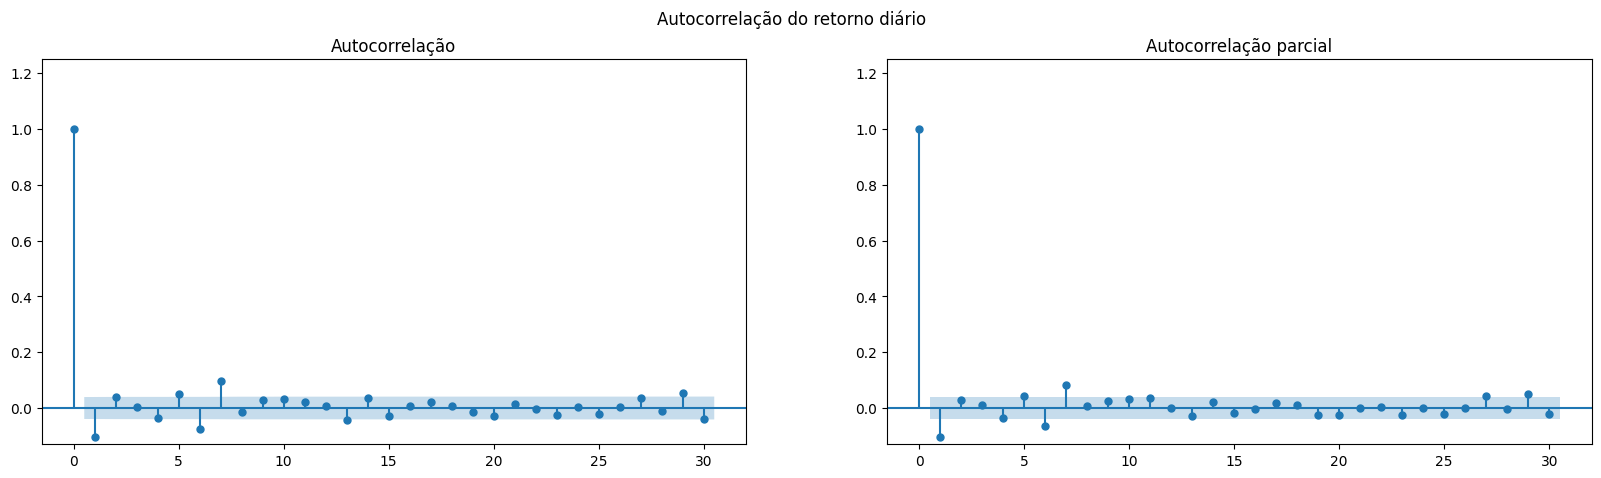

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))

plot_acf(df['daily_return'], lags = 30, title = 'Autocorrelação', auto_ylims = True, ax = axes[0])
plot_pacf(df['daily_return'], lags = 30, title = 'Autocorrelação parcial', auto_ylims = True, ax = axes[1])
plt.suptitle('Autocorrelação do retorno diário')
plt.show()

O retorno de ontem (return_lag_1) parace ter significância no retorno diário.

## Construção do modelo de regressão

In [17]:
# definindo variáveis preditoras e variável alvo
remove_features = ['open', 'high', 'low', 'close', 'volume', 'sma_21', 'ema_50', 'obv', 'daily_return']

X = df.drop(columns=remove_features)
y = df['close']

In [ ]:
# Precisamos defasar as features para não usar dados do futuro e evitar overfitting
X_shifted = X.shift(1).dropna()
y = y.loc[X_shifted.index]

In [19]:
# divisão entre treino e teste (30 dias de pregão, conforme requisito) de forma cronológica (sem aleatoriedade)
X_train, X_test, y_train, y_test = train_test_split(X_shifted, y, test_size=30, shuffle=False)

print(f"Tamanho do treino: {len(X_train)} amostras")
print(f"Tamanho do teste: {len(X_test)} amostras")

Tamanho do treino: 2451 amostras
Tamanho do teste: 30 amostras


In [ ]:
# definindo modelos de regressão
seed = 42
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=-1),
    'XGBoost Regressor': xgb.XGBRegressor(random_state=seed, n_jobs=-1)
}

In [21]:
# treinando os modelos
for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_train, y_train)

print("Todos os modelos foram treinados!")

Treinando Linear Regression...
Treinando Decision Tree Regressor...
Treinando Random Forest Regressor...
Treinando XGBoost Regressor...
Todos os modelos foram treinados!


In [22]:
# comparando o desempenho dos modelos
resultados_regressao = {}

for nome, modelo in models.items():
    y_pred = modelo.predict(X_test)
    
    # Calcula as métricas de regressão
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Calcula a acurácia direcional
    # Compara o sinal (+) ou (-) da previsão com o sinal do valor real
    acuracia_direcional = np.mean(np.sign(y_pred) == np.sign(y_test)) * 100
    
    # Armazena todos os resultados no dicionário
    resultados_regressao[nome] = {
        'MAE': mae,
        'MSE': mse,
        'R2 Score': r2,
        'Acurácia Direcional (%)': acuracia_direcional
    }


df_resultados = pd.DataFrame.from_dict(resultados_regressao, orient='index').sort_values(by='Acurácia Direcional (%)', ascending=False)
df_resultados

,MAE,MSE,R2 Score,Acurácia Direcional (%)
Linear Regression,4131.712284,1.844650e+07,-11.500860,100.0
Decision Tree Regressor,6664.666667,4.612849e+07,-30.260447,100.0
Random Forest Regressor,6464.989000,4.401272e+07,-28.826631,100.0
XGBoost Regressor,5528.181152,3.310479e+07,-21.434519,100.0


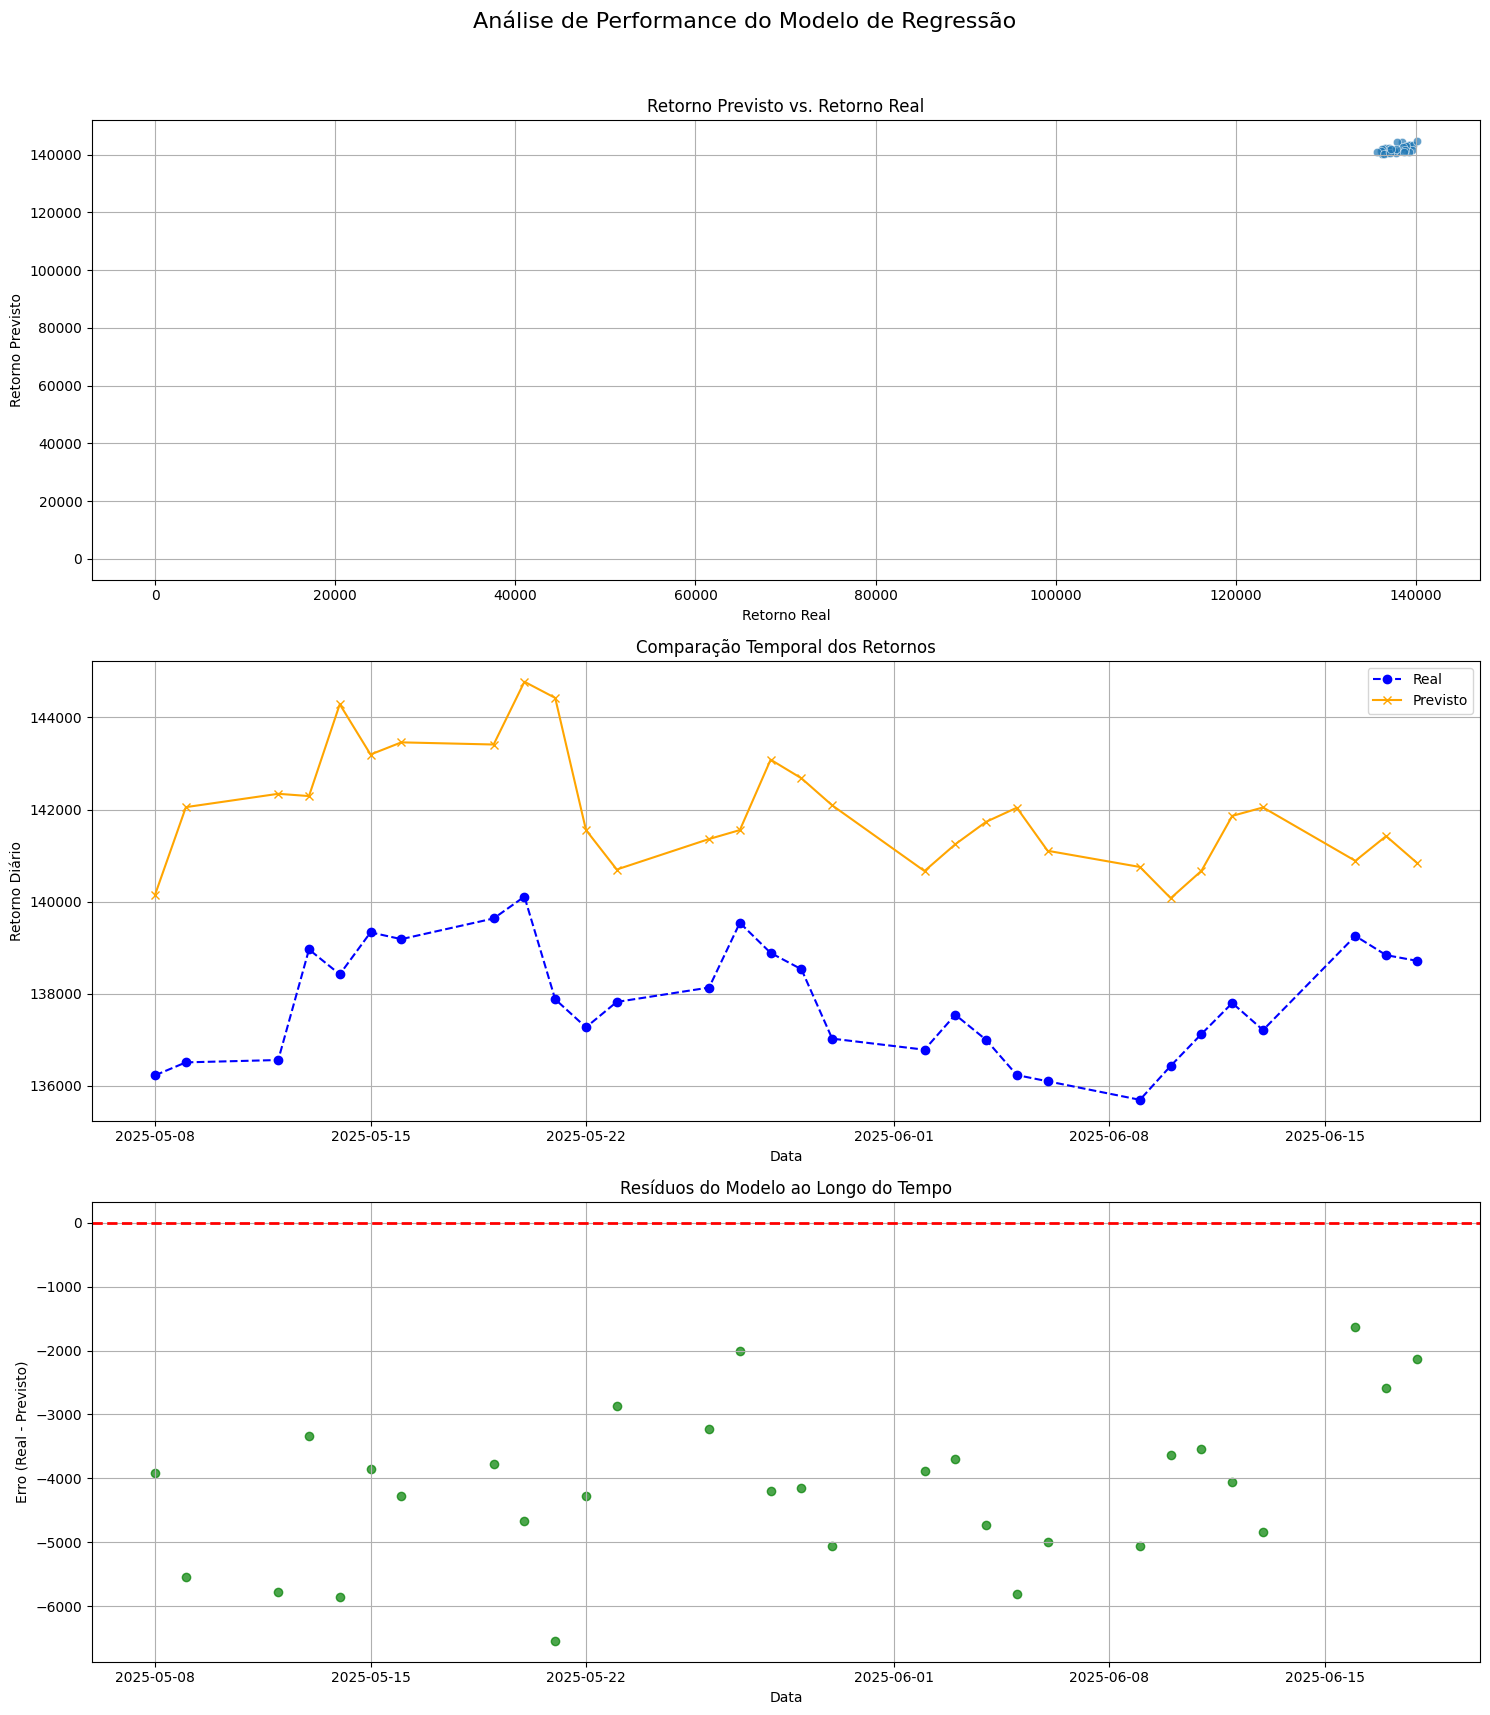

In [23]:
best_model_name = df_resultados.idxmax().loc['R2 Score']
best_model = models[best_model_name]

# 2. Criar um DataFrame com os resultados para facilitar a plotagem
df_resultados = pd.DataFrame({
    'Retorno Real': y_test,
    'Retorno Previsto': best_model.predict(X_test)
})

# 3. Calcular os erros (resíduos)
df_resultados['Residuos'] = df_resultados['Retorno Real'] - df_resultados['Retorno Previsto']

# --- Criação dos Gráficos ---
fig, axes = plt.subplots(3, 1, figsize=(15, 18))
fig.suptitle('Análise de Performance do Modelo de Regressão', fontsize=16)

# Gráfico 1: Scatter Plot (Previsto vs. Real)
sns.scatterplot(ax=axes[0], x='Retorno Real', y='Retorno Previsto', data=df_resultados, alpha=0.7)
axes[0].plot([-0.05, 0.05], [-0.05, 0.05], color='red', linestyle='--', lw=2) # Linha de 45 graus (previsão perfeita)
axes[0].set_title('Retorno Previsto vs. Retorno Real')
axes[0].set_xlabel('Retorno Real')
axes[0].set_ylabel('Retorno Previsto')
axes[0].grid(True)

# Gráfico 2: Série Temporal (Linhas do Previsto e Real ao Longo do Tempo)
axes[1].plot(df_resultados.index, df_resultados['Retorno Real'], label='Real', color='blue', marker='o', linestyle='--')
axes[1].plot(df_resultados.index, df_resultados['Retorno Previsto'], label='Previsto', color='orange', marker='x', linestyle='-')
axes[1].set_title('Comparação Temporal dos Retornos')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Retorno Diário')
axes[1].legend()
axes[1].grid(True)

# Gráfico 3: Análise de Resíduos (Erros)
axes[2].scatter(df_resultados.index, df_resultados['Residuos'], alpha=0.7, color='green')
axes[2].axhline(y=0, color='red', linestyle='--', lw=2) # Linha de erro zero
axes[2].set_title('Resíduos do Modelo ao Longo do Tempo')
axes[2].set_xlabel('Data')
axes[2].set_ylabel('Erro (Real - Previsto)')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

## Prophet

In [14]:
from prophet import Prophet

/home/umpuela/Downloads/FIAP/FASE 2/TechChallenge/Analise_Indice_Ibovespa/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:
# formatando os dados como o prophet precisa
df_prophet = df.reset_index().rename(columns={'ds': 'ds', 'close': 'y'})

features_to_use = ['rsi_14', 'atr_14', 'momentum_5', 'daily_return']
for feature in features_to_use:
    df_prophet[f'{feature}_lag1'] = df_prophet[feature].shift(1)

df_prophet.dropna(inplace=True)

In [62]:
# inicializando o modelo e adicionando as features
m = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
m.add_regressor('atr_14_lag1')
m.add_regressor('daily_return_lag1')
m.add_regressor('rsi_14_lag1')
m.add_regressor('momentum_5_lag1')

# divisão treino e teste
train_prophet = df_prophet.iloc[:-30]
test_prophet = df_prophet.iloc[-30:]

# treinando o modelo
m.fit(train_prophet)

19:44:40 - cmdstanpy - INFO - Chain [1] start processing
19:44:41 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
# df que vai conter as predições
future = m.make_future_dataframe(periods=30, freq='B')

# adicionando as features
future_with_regressors = pd.merge(
    future, 
    df_prophet[['ds', 'rsi_14_lag1', 'atr_14_lag1', 'momentum_5_lag1', 'daily_return_lag1']], 
    on='ds', 
    how='left'
)

In [65]:
# predição
forecast = m.predict(future_with_regressors)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2476,2025-06-12,130525.659857,125199.152883,135482.665471
2477,2025-06-13,131050.174089,125755.338564,136234.793764
2478,2025-06-16,130589.703331,125306.896298,135669.613082
2479,2025-06-17,131525.326059,126456.451910,136376.362416
2480,2025-06-18,131546.600522,126150.729845,136617.822889


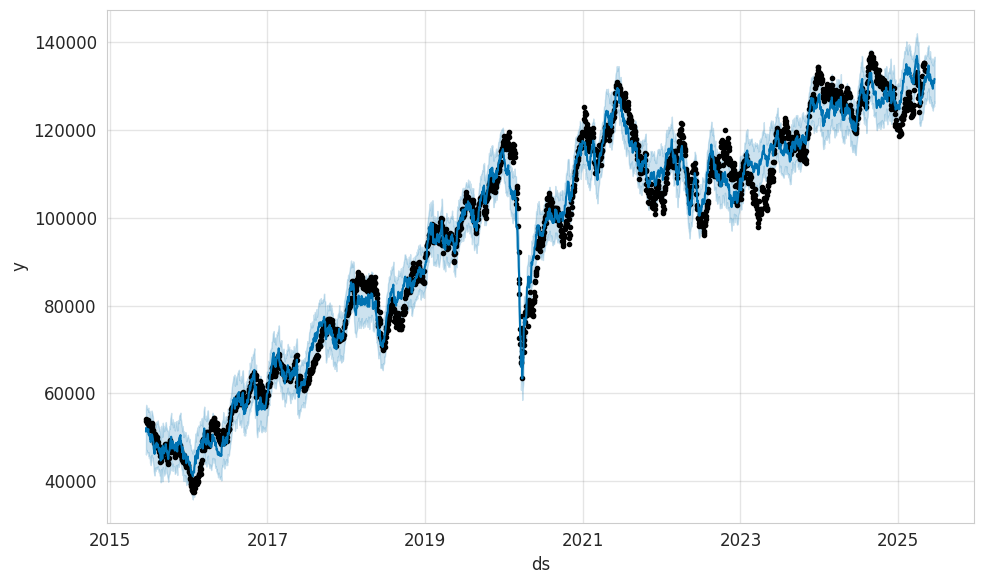

In [66]:
# previsão em azul
fig1 = m.plot(forecast)

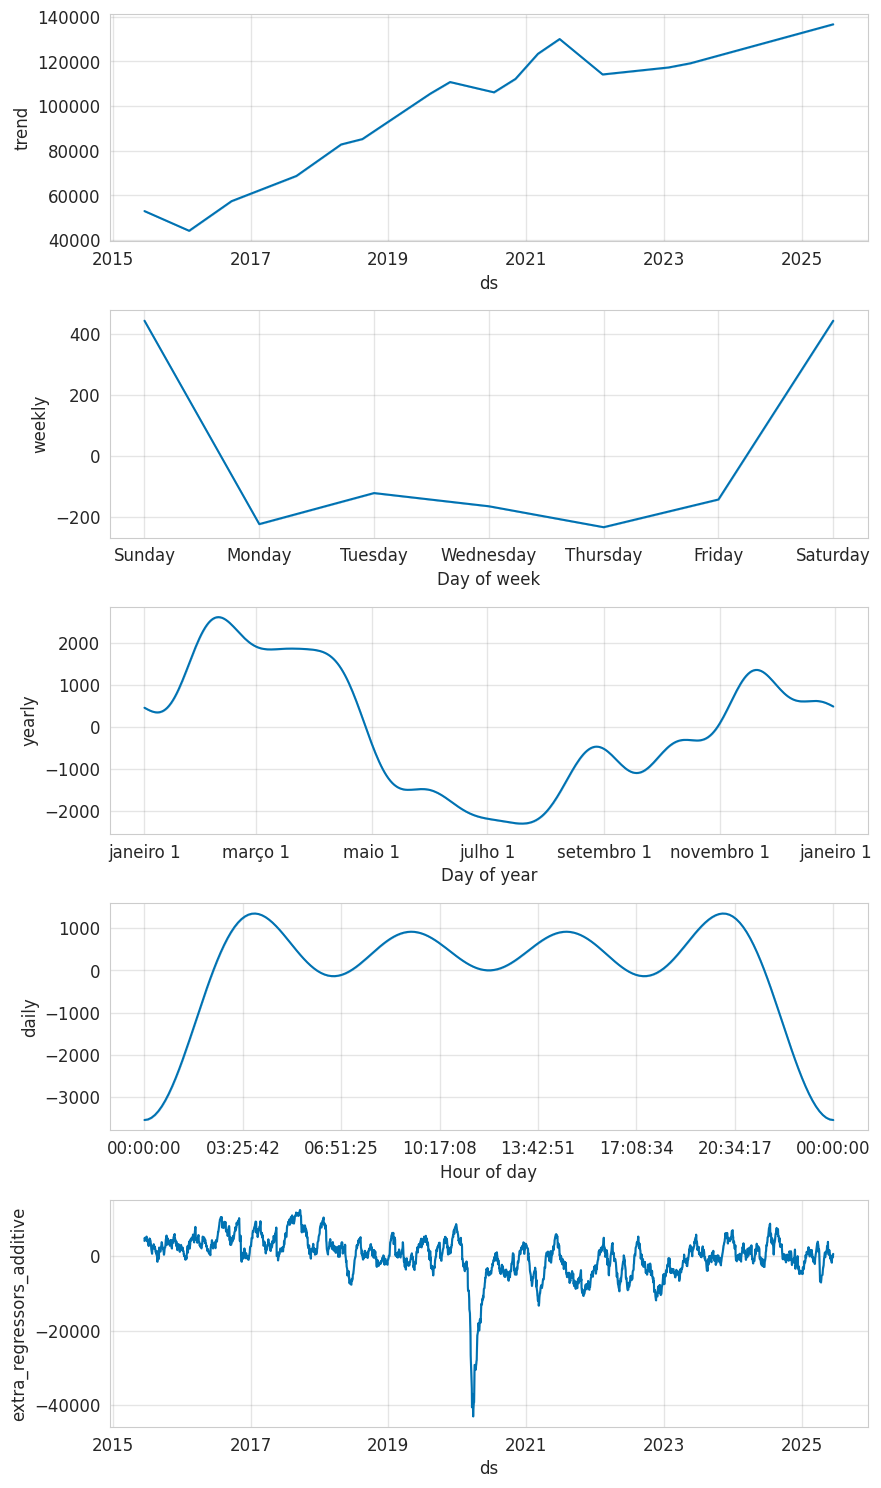

In [67]:
fig2 = m.plot_components(forecast)
